# Clase 17: Forecasting

**MDS720: Laboratorio de Programación Científica para Ciencia de Datos**

## Objetivos de la clase

- Introducir al estudiante a la disciplina de hacer forecasting
- Entender conceptos fundamentales de una serie de tiempo: Estacionariedad, Ruido Blanco
- Aprender como descompones una serie de tiempo en sus componentes de tendencia, estacionalidad, ciclicidad e irregular
- Entender el paradigma de modelo híbrido y como puede ser usado para hacer forecast
- Aplicar los conocimientos adquiridos a lo largo del curso para generar un forecast usando modelos híbridos y `sklearn`

## Resumen Ejecutivo

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*1fcxme1rEwgFGaY2BW2EAA.png" style="width: 35%;">
</div>

El forecasting es la disciplina de predecir los valores futuros de una serie de tiempo en función de un factor temporal $t$:

$$\hat x_t = h(t)$$

Teóricamente, es posible descomponer el factor temporal $t$ en los siguientes componentes:

- Tendencia o *Trend* ($T$)
- Estacionalidad o *Seasonal* ($E$)
- Ciclicidad o *Cyclical* ($C$)
- Irregular o *Residuos* ($\epsilon$)

Los primeros 3 componentes capturan la dinámica de la serie de tiempo de interés. El factor Irregular captura todo lo que no puede ser explicado por el factor temporal.

**El objetivo de esta clase es aislar nuestro problema para que sólo dependa del componente irregular $\epsilon$.**

Esto lo haremos asegurando que $\epsilon$ cumpla la prodiedad de <u>estacionariedad</u>:

$$\epsilon \sim N(\mu, \sigma^2)$$

Una forma tradicional de abordar esto es asumir aditividad entre los componentes:

$$x_t = h(T, E, C, \epsilon)$$
$$x_t = T + E + C + \epsilon$$
$$x_t = z_t + \epsilon$$

Podemos usar **modelos híbridos** para separar el problema con:
- Un modelo $g_1$ que estime los componentes temporales $z_t$:
$$\hat z_t = g_1(X_1)$$
- Un modelo $g_2$ que estime el componente irregular $\epsilon$:
$$\hat \epsilon = g_2(X_2)$$
$$\hat \epsilon \sim (x_t - \hat z_t)$$

donde:

- $X_1$ representa los valores pasados de $x_t$
- $X_2$ refiere a variables exógenas que podrían explicar $x_t$
- $X = X_1 \cup X_2$

Finalmente, la predicción final es la suma de ambas predicciones:

$$\hat x_t = \hat z_t + \hat \epsilon$$

## Dataset a ocupar

Para esta clase ocuparemos el dataset de [Daily Climate time series data](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data), el cual contiene datos metereológicos desde el 1 de Enero de 2013 hasta el 24 de Abril de 2017 de la ciudad de Delhi, India. La idea de esta clase es que podamos usar este dataset para entrenar un modelo que pueda generar un **forecast sobre la temperatura** a partir de datos del pasado.

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/Stormclouds.jpg" style="width: 50%;">
</div>

In [2]:
import pandas as pd
import numpy as np

path_df = "https://raw.githubusercontent.com/MDS7202/MDS7202/main/recursos/2024-01/forecasting/temperatures.csv"
df = pd.read_csv(path_df) # leer datos
df['date'] = pd.to_datetime(df['date']) # formatear date como datetime

df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Holdout

Como en todo problema de ML, un aspecto fundamental en el forecasting es la separación de los datos en conjuntos de entrenamiento y test. Sin embargo y a diferencia del enfoque clásico, nuestra separación de train-test debe **respetar un orden temporal en los datos**, pues recordemos que debemos **predecir el futuro usando datos del pasado**. Bajo esta premisa, la idea entonces es:

1. Separar los datos usando un corte temporal definido por el usuario
2. Entrenar el modelo usando la primera fracción ("datos del pasado")
3. Evaluar el modelo usando la segunda fracción ("datos del futuro")

Para este problema en particular buscaremos predecir la temperatura promedio de 2017 usando data de los años 2013-2016.

In [3]:
df['date'].max()

Timestamp('2017-04-24 00:00:00')

In [4]:
# Holdout

df['set'] = np.where(df.date >= pd.Timestamp('2017-01-01'), 'Test', 'Train')

train = df[df['set'] == 'Train'].copy()
test = df[df['set'] == 'Test'].copy()

target = 'meantemp'

X_train = train.drop(columns = ['set'])
y_train = train[target].copy()

X_test = test.drop(columns = ['set'])
y_test = test[target].copy()

print(f'% destinado a train: {len(train) / len(df):.2f}')
print(f'% destinado a test: {len(test) / len(df):.2f}')

X_train

% destinado a train: 0.93
% destinado a test: 0.07


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1456,2016-12-27,16.850000,67.550000,8.335000,1017.200000
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [5]:
import plotly.express as px

# plot
fig = px.scatter(df, x = df.date, y=target, title='Temperaturas diarias', color = 'set')
fig.update_traces(marker=dict(size=3.5))
fig.show()

## ¿Qué significa hacer forecasting?

En pocas palabras, **forecasting** es la disciplina de predecir los valores **futuros** de una serie de tiempo, dados sus valores pasados. Matemáticamente, podríamos expresar esto como:

$$x_t = h(x_{t-m})$$

donde en este caso $x_{t-m}$ representa los $m$ valores pasados de la variable $x$.

> **Pregunta:** ¿Podemos usar valores pasados de otras variables?

Ejemplos de forecasting:
- Predecir la temperatura del dia siguiente usando como input los últimos 5 años de temperaturas registradas.
- Predecir la nota del siguiente laboratorio dadas las notas de los últimos 3 laboratorios
- Predecir el nivel de inflación dadas las últimas cifras económicas

> **Pregunta:** Está el forecasting limitado a problemas de regresión?

**IMPORTANTE**

Cuando hacemos forecasting, el primer supuesto (y el más importante) es que **el futuro depende del pasado**. Si bien esto puede parecer obvio, vale la pena tenerlo presente, pues esto no siempre se cumple para todos los problemas.
Veamos lo anterior con un ejemplo:

¿Cuáles de estos casos son forecasteables?
1. Predecir el lanzamiento de una moneda dado los 10 lanzamientos anteriores
2. Predecir el consumo de electricidad de una casa a partir del consumo de los 3 meses anteriores
3. Predecir la temperatura del lunes a partir de temperaturas históricas
4. Predecir el siguiente número de lotería a partir de los 10 números de lotería pasados

## ¿Qué es una serie de tiempo?

Para simplificar el concepto, una serie de tiempo es un **conjunto de observaciones recolectadas de manera secuencial en el tiempo**. Es esencial enfocarnos en la palabra `tiempo`. Al repetir la misma observación en distintos momentos, generamos una serie de tiempo. Veamos algunos ejemplos de series de tiempo:

- N° de barras de chocolate que consumo cada mes
- Peso al inicio de cada mes
- Precio de cierre de una acción
- Precipitación diaria en una localidad
- Ritmo cardíaco de una persona en una ventana de tiempo


En esta clase, exploraremos cómo estas secuencias temporales pueden analizarse para revelar patrones importantes y cómo se pueden hacer predicciones basadas en ellas.

## Estacionariedad


En el análisis de series de tiempo, la estacionariedad es de suma importancia y es un supuesto clave para que muchos métodos de forecast funcionen. Paradójicamente, **la mayoría de las series de tiempo del mundo real no son estacionarias**. Por lo tanto, entendamos un poco mejor que significa que una serie sea o no estacionaria.

Una de las más claras e intuitivas para entender este concepto es considerar la distribución de probabilidad de los datos de una serie de tiempo. Decimos que **una serie de tiempo es estacionaria cuando su distribución de probabilidad se mantiene <u>constante</u> en el tiempo**. Es decir, si seleccionamos diferentes intervalos de tiempo, la distribución de los datos en estos intervalos debería ser la misma.

Requerimientos para ser estacionaria:

$$\mu = \text{constante}$$
$$\sigma = \text{constante}$$
$$\text{sin estacionalidad}$$

Entonces si alguno de estos 3 requerimientos no se cumple, entonces no podemos considerar una serie estacionaria.

A partir de las siguientes series, pueden identificar qué series son estacionarias?

<div style="text-align: center;">
    <img src="../../recursos/2024-01/forecasting/plots_stationarity.png" style="width: 70%;">
</div>
<center>Fuente: Joseph, M. (2022). <i>Modern Time Series Forecasting with Python: Explore industry-ready time series forecasting using modern machine learning and deep learning</i</center>

## Ruido Blanco

El caso más deseable de una serie de tiempo estacionaria es el **ruido blanco**. Este tipo de series se caracteriza por ser una serie temporal en la que cada valor es una variable aleatoria independiente e idénticamente distribuida (i.i.d.). En términos más sencillos, esto significa que cada dato en la serie no tiene relación o dependencia con los datos anteriores o posteriores, y todos los datos provienen de la misma distribución estadística.

Una de las propiedades clave del ruido blanco es que su media es igual a 0 y su varianza es constante en el tiempo. Si asumimos que la distribución de la serie es gaussiana, podríamos caracterizar un ruido blanco como:

$$X_t \sim N(0, \sigma^2)$$

> **Pregunta:** Es posible definir un ruido blanco con otra distribución? Qué implicancias podría tener esto?

Veamos visualmente una serie que sigue esta distribución:

In [6]:
import numpy as np

n = 1000 # largo de la serie
time = np.arange(n) # valores tiempo
values = np.random.uniform(low=-1, high=1, size=n)*100

fig = px.line(x = time, y=values, title='Ruido Blanco')
fig.show()

In [7]:
import numpy as np

n = 1000 # largo de la serie
time = np.arange(n) # valores tiempo
values = np.random.randn(n)*100 # sample

fig = px.line(x = time, y=values, title='Ruido Blanco')
fig.show()

## Descomponiendo una serie de tiempo

Ya que conocemos lo que significa que una serie sea estacionaria, veamos ahora cómo podemos podemos transformar nuestra serie de tiempo no estacionaria a estacionaria.

Uno de los métodos más usuales para asegurar la estacionariedad en la serie es simplemente **diferenciando** la variable objetivo, es decir:

$$Z_t = Y_t - Y_{t-1}$$

donde en este caso $Z_t$ se transforma en la nueva serie target con propiedad de estacionariedad.

Otra forma usual (y la que profundizaremos en esta clase) es a través de la **descomposición estructural de la serie de tiempo**. Intuitivamente, la idea es descomponer y separar la serie de tiempo en diferentes componentes que generan que la serie sea no estacionaria, de manera que podamos entrenar nuestro modelo *controlando* por esos componentes. De esta manera y acorde a la literatura, cualquier serie de tiempo $Y$ puede ser descompuesta en los siguientes elementos:
- **Tendencia**
- **Estacionalidad**
- **Ciclicidad**
- **Irregular (Residuos)**

Donde en este caso los componentes Tendencia, Estacionalidad y Ciclicidad afectan negativamente a la propiedad de estacionariedad. Si logramos controlar de manera efectiva por estos componentes, nuestra serie (que en este caso está compuesta únicamente por el término Irregular) debería seguir propiedades de una serie estacionaria (media y varianza constantes). De esta manera, el objetivo de este método es buscar que el término Irregular sea estacionario, es decir:

$$X_t \sim N(\mu, \sigma^2)$$

donde en este caso se asume que los errores distribuyen de forma gaussiana.

Para relacionar estos componenentes, la literatura asume las siguientes 2 formas:

- **Aditiva:** $Y = T + E + C + I$
- **Multiplicativa:** $Y = T \cdot E \cdot C \cdot I$

Pasemos a ver en detalle cada uno de estos componentes:

### Tendencia

La **tendencia** representa un cambio sostenido en el tiempo en la **media** de una serie temporal, caracterizándose por un movimiento fluido y constante en una dirección específica. Cuando la serie muestra un movimiento **ascendente**, hablamos de una **tendencia al alza**; por el contrario, si se desplaza hacia **abajo**, se identifica una **tendencia a la baja**. Veamos algunos ejemplos:

<div style="text-align: center;">
    <img src="https://storage.googleapis.com/kaggle-media/learn/images/ZdS4ZoJ.png" style="width: 65%;">
</div>

#### ¿Cómo podemos representar la tendencia?

Una forma fácil de representar la tendencia es a través de una regresión lineal de la variable objetivo en función del tiempo.

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):

        self.init_date = None

    def fit(self, X, y=None):

        assert isinstance(X, pd.DataFrame), 'df must be a pandas DataFrame'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        self.init_date = X.date.iloc[0]

        return self

    def transform(self, X):

        X = X.copy()

        assert self.init_date is not None, 'transformer must be fitted first!'
        assert isinstance(X, pd.DataFrame), 'df must be a pandas DataFrame'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        final_date = X.date.iloc[-1] # last date of X

        # generate trend series
        count = (final_date - self.init_date).days + 1
        X['trend'] = [i for i in range(count)][-len(X):]

        return X[['trend']]

    def fit_transform(self, X, y=None):

        X = X.copy()

        assert isinstance(X, pd.DataFrame), 'df must be a pandas Dataframe'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        self.trend = len(X)
        self.init_date = X.date.iloc[0]

        final_date = X.date.iloc[-1] # last date of X

        # generate trend series
        count = (final_date - self.init_date).days + 1
        X['trend'] = [i for i in range(count)][-len(X):]

        return X[['trend']]

transformer = TimeTransformer()
transformer.fit_transform(X_train) # notar que sólo usa la variable "date"

,trend
0,0
1,1
2,2
3,3
4,4
...,...
1456,1456
1457,1457
1458,1458
1459,1459


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

pipeline = Pipeline([
    ('time_features', TimeTransformer()),
    ('ols', LinearRegression())
])

pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

y_pred = np.concatenate([train_pred, test_pred])

y_pred.shape

(1575,)

In [10]:
# plot
fig = px.scatter(df, x=df.date, y=target, title='Forecast de Temperaturas', color='set')
fig.add_scatter(x=df.date, y=y_pred, mode='lines', name='Prediction', line=dict(color='green', width=3))
fig.update_traces(marker=dict(size=3.5))
fig.show()

Noten como la pendiente de la regresión es ligeramente positiva :(

> **Pregunta:** ¿Qué otras formas se les ocurre de modelar la tendencia?

> **Pregunta:** ¿La tendencia puede ser no lineal?

Veamos ahora que tan bien ajusta nuestra predicción a los datos. Como en este caso estamos resolviendo un problema de regresión, podemos usar `Mean Absolute Error`:

In [11]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, train_pred)
mae_test = mean_absolute_error(y_test, test_pred)

print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')

MAE Train: 6.30
MAE Test: 7.36


Como era de esperar y considerando la aproximación simplista que utilizamos, el modelo entrenado tiene una performance altamente mejorable. Sin embargo nos entrega un excelente baseline para empezar a mejorar nuestro forecast.

Veamos ahora la distribución de los errores en para la serie:

In [12]:
# calculamos errores de train y test
error_train = y_train - train_pred
error_test = y_test - test_pred
error = pd.concat([error_train, error_test])

# graficamos errores
fig = px.line(x = df.date, y=error, title='Error en la predicción', color = df.set)
fig.show()

A partir del gráfico, se observa que existe un **comportamiento estacional en la serie**, alcanzando máximos en los meses de Julio y mínimos en los meses de Noviembre. Por otro lado, se observa que a medida que pasa el tiempo la amplitud de los ciclos es cada vez mayor.

En otras palabras, **los errores aún no se comportan como ruido blanco**. Podemos comprobar lo anterior implementando el Test ADF:

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(error)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.3144727468431507
p-value: 0.16734269978440935
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


Existe alguna forma de mejorar esto?

### Estacionalidad

Decimos que una serie temporal muestra **estacionalidad** cuando hay un **cambio regular y periódico en la media** de la serie. Los cambios estacionales suelen seguir el reloj y el calendario, con repeticiones a lo largo de un día, una semana o un año siendo comunes. La estacionalidad a menudo está impulsada por los ciclos del mundo natural a lo largo de días y años, o por convenciones del comportamiento social relacionadas con fechas y horas.

<div style="text-align: center;">
    <img src="https://storage.googleapis.com/kaggle-media/learn/images/ViYbSxS.png" style="width: 65%;">
</div>

#### ¿Cómo podemos representar el componente estacional?

Una de las formas más conocidas de modelar la estacionalidad de una serie temporal es a través de los **términos de Fourier**. Estos términos se erigen sobre el teorema de Fourier, el cual afirma que cualquier función períodica puede ser descompuesta en la suma de funciones seno y coseno. La representación matemática de lo anterior puede ser representada por la siguiente identidad:

$$f(t) = a_0 + \sum_{n=1}^{\infty} \left( a_n \cos\left(\frac{2\pi n t}{P}\right) + b_n \sin\left(\frac{2\pi n t}{P}\right) \right)$$

donde los términos $a_0$, $a_n$ y $b_n$ son usualmente ajustados a partir de algún modelo. Bajo esa consideración, los términos de fourier dependen sólo de 2 variables:
  - La **periodicidad** del componente estacional $P$
  - El **número de términos** de fourier $n$

La periodicidad es el número de períodos (unidades de la serie de tiempo) entre cada intervalo. Como tenemos datos diarios de temperaturas para diferentes años, especificar periodicidad igual a 365 basta para este problema (noten como en el gráfico de temperaturas la diferencia entre cada intervalo se aproxima a 365). Por otro lado, usualmente incluir 4 o 5 términos de fourier es suficiente para modelar el componente estacional.

A partir de todo lo anterior, podemos implementar de manera nativa los términos de Fourier de la siguiente manera:

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, n = 4, p = 365):

        self.init_date = None
        self.n = n
        self.p = p

    def fit(self, X, y=None):

        '''
        Realiza el fit sobre los datos --> guarda la fecha de inicio de entrenamiento.
        '''

        assert isinstance(X, pd.DataFrame), 'df must be a pandas DataFrame'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        self.init_date = X.date.iloc[0]

    def transform(self, X):

        '''
        Realiza el transform sobre el conjunto X, retornando los términos de fourier.
        '''

        X = X[['date']].copy()

        assert self.init_date is not None, 'transformer must be fitted first!'
        assert isinstance(X, pd.DataFrame), 'df must be a pandas Dataframe'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        final_date = X.index[-1] # last date of X
        final_date = X.date.iloc[-1] # last date of X

        # generate trend series
        count = (final_date - self.init_date).days + 1
        X['trend'] = [i for i in range(count)][-len(X):]

        # generate fourier terms
        fourier = self.get_fourier_terms(X['trend'], self.n, self.p)

        # concatenate trend + fourier
        X = pd.concat([X, fourier], axis = 1).drop(columns = 'date')

        return X

    def fit_transform(self, X, y=None):

        '''
        implementa el método fit y transform a la vez.
        '''

        X = X[['date']].copy()

        assert isinstance(X, pd.DataFrame), 'df must be a pandas Dataframe'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        self.trend = len(X)
        self.init_date = X.date.iloc[0]

        final_date = X.date.iloc[-1] # last date of X

        # generate trend series
        count = (final_date - self.init_date).days + 1
        X['trend'] = [i for i in range(count)][-len(X):]

        # generate fourier terms
        fourier = self.get_fourier_terms(X['trend'], self.n, self.p)

        # concatenate trend + fourier
        X = pd.concat([X, fourier], axis = 1).drop(columns = 'date')

        return X

    def get_fourier_terms(self, serie, n, p):

        '''
        Obtiene los términos de fourier de una serie
        '''

        terms = []
        for i in range(1, n + 1):
            sine_term = np.sin(2 * np.pi * i * serie / p)
            cosine_term = np.cos(2 * np.pi * i * serie / p)
            terms.extend([sine_term, cosine_term])

        fourier = np.column_stack(terms)
        fourier = pd.DataFrame(fourier, columns = [f'fourier_{i}' for i in range(n * 2)], index = serie.index) # este paso es opcional

        return fourier

transformer = TimeTransformer(n = 4, p = 365)
transformer.fit_transform(X_train) # notar que sólo usa la variable "date"

,trend,fourier_0,fourier_1,fourier_2,fourier_3,fourier_4,fourier_5,fourier_6,fourier_7
0,0,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000
1,1,1.721336e-02,0.999852,3.442161e-02,0.999407,5.161967e-02,0.998667,6.880243e-02,0.997630
2,2,3.442161e-02,0.999407,6.880243e-02,0.997630,1.031017e-01,0.994671,1.372788e-01,0.990532
3,3,5.161967e-02,0.998667,1.031017e-01,0.994671,1.543088e-01,0.988023,2.051045e-01,0.978740
4,4,6.880243e-02,0.997630,1.372788e-01,0.990532,2.051045e-01,0.978740,2.719582e-01,0.962309
...,...,...,...,...,...,...,...,...,...
1456,1456,-6.880243e-02,0.997630,-1.372788e-01,0.990532,-2.051045e-01,0.978740,-2.719582e-01,0.962309
1457,1457,-5.161967e-02,0.998667,-1.031017e-01,0.994671,-1.543088e-01,0.988023,-2.051045e-01,0.978740
1458,1458,-3.442161e-02,0.999407,-6.880243e-02,0.997630,-1.031017e-01,0.994671,-1.372788e-01,0.990532
1459,1459,-1.721336e-02,0.999852,-3.442161e-02,0.999407,-5.161967e-02,0.998667,-6.880243e-02,0.997630


In [15]:
# definir Pipeline
pipeline = Pipeline([
    ('time_features', TimeTransformer(n = 4, p = 365)),
    ('ols', LinearRegression())
])

# entrenar y predecir
pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

y_pred = np.concatenate([train_pred, test_pred])

In [16]:
# plot
fig = px.scatter(df, x=df.date, y=target, title='Forecast de Temperaturas', color='set')
fig.add_scatter(x=df.date, y=y_pred, mode='lines', name='Prediction', line=dict(color='green', width=3))
fig.update_traces(marker=dict(size=3.5))
fig.show()

Noten como en muy pocas lineas de código y **usando solo features que dependen del tiempo**, pudimos capturar el componente estacional y lograr un mejor ajuste a la serie. Calculemos ahora el MAE:

In [17]:
mae_train = mean_absolute_error(y_train, train_pred)
mae_test = mean_absolute_error(y_test, test_pred)

print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')

MAE Train: 1.68
MAE Test: 2.07


Como era de esperar, obtuvimos una mejora notable en nuestra métrica. Finalmente, observemos como se comportan los errores de nuestra predicción:

In [18]:
# calculamos errores de train y test
error_train = y_train - train_pred
error_test = y_test - test_pred
error = pd.concat([error_train, error_test])

# graficamos errores
fig = px.line(x = df.date, y=error, title='Error en la predicción', color = df.set)
fig.show()

Noten como ahora los errores tienen un comportamiento tienen un comportamiento mucho más parecido a una serie estacionaria. Como antes, podemos verificar esto mediante el test ADF:

In [19]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(error)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.517313049797337
p-value: 2.0795570178314642e-29
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


Pudiendo concluir que efectivamente nuestra serie es estacionaria.

Veamos ahora como podemos seguir mejorando nuestro modelo:

#### Paréntesis: Corrigiendo Heterocedasticidad

Un fenómeno usual al trabajar en forecasting es detectar la presencia de cambios en la varianza de los errores a lo largo del tiempo. Visualmente esto se puede apreciar cuando la **amplitud** de la serie cambia en el tiempo. Estadísticamente, esto se puede comprobar mediante el **test de White**.

A este fenómeno se le llama **heterocedasticidad** y es otra de las razones principales por las que una serie puede no ser estacionaria. Si bien no es algo que esté presente en el ejemplo de la clase, es imperativo que sepamos como lidiar con este tipo de problemas para el futuro.

<div style="text-align: center;">
    <img src="../../recursos/2024-01/forecasting/stationarity.png" style="width: 60%;">
</div>
<center>Fuente: Joseph, M. (2022). <i>Modern Time Series Forecasting with Python: Explore industry-ready time series forecasting using modern machine learning and deep learning</i></center>


Una de las maneras mas simples de atacar este problema es aplicando una transformación monotónica a la variable objetivo. La idea es aplicar una transformación que reduzca la varianza y haga la distribución de los datos un poco más *normal*.

Existen diferentes transformaciones que pueden lograr esto (ver [enlace](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer)). Una de las más conocidas es la transformación **Box-Cox**, la cual viene definida por la siguiente expresión:

\begin{equation}
y_i^{(\lambda)} = \begin{cases}
\frac{y_i^\lambda - 1}{\lambda} & \text{si } \lambda \neq 0 \\
\log(y_i) & \text{si } \lambda = 0
\end{cases}
\end{equation}

Intuitivamente, podríamos decir que la transformación Box-Cox es una generalización de la transformación logarítmica (cuando $\lambda = 0$). En diferentes valores de $\lambda$, esta transformación imita otras como $y^2$ cuando $\lambda = 2$, $\frac{1}{\sqrt{y}}$ cuando $\lambda = -0.5$, $\sqrt{y}$ cuando $\lambda = 0.5$, y así sucesivamente. Cuando $\lambda = 1$, no hay una transformación significativa.

La principal desventaja de esta transformación es que acepta únicamente datos estrictamente positivos. Además, agrega pasos adicionales en el pipeline al tener que transformar y de-transformar los datos.

Veamos como implementar la transformación Box-Cox usando `sklearn`:


In [20]:
y_train

0       10.000000
1        7.400000
2        7.166667
3        8.666667
4        6.000000
          ...    
1456    16.850000
1457    17.217391
1458    15.238095
1459    14.095238
1460    15.052632
Name: meantemp, Length: 1461, dtype: float64

In [21]:
from sklearn.preprocessing import PowerTransformer

target_scaler = PowerTransformer(method = 'box-cox') # inicializar transformer

y_train_scaled = target_scaler.fit_transform(np.array(y_train, ndmin = 2).T) # fit y transform

y_train_scaled

array([[-1.87015638],
       [-2.07205742],
       [-2.08847237],
       ...,
       [-1.36947875],
       [-1.48853594],
       [-1.38915186]])

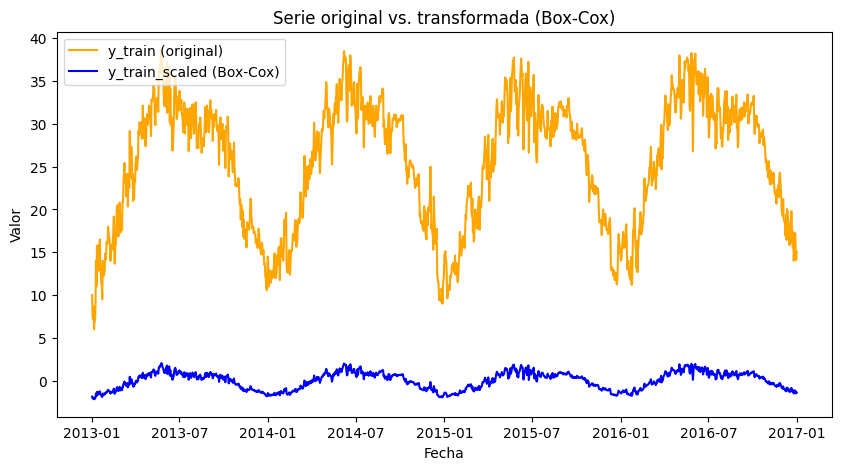

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train['date'], y_train, label='y_train (original)', color='orange')
plt.plot(train['date'], y_train_scaled.reshape(-1), label='y_train_scaled (Box-Cox)', color='blue')
plt.title('Serie original vs. transformada (Box-Cox)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

Con la transformación, volvemos a correr el modelo sobre el target transformado:

In [23]:
# esto es solo un esqueleto
pipeline.fit(X_train, y_train_scaled)
y_pred = pipeline.predict(X_test) # generamos predicción
y_pred = target_scaler.inverse_transform(y_pred) # paso importante: volvemos ahora al dominio original de los datos
y_pred[:5]

array([[15.48991849],
       [15.45329409],
       [15.42271687],
       [15.39827457],
       [15.38004688]])

### Ciclicidad

Una manera particularmente frecuente en la que se manifiesta la dependencia intertemporal en las series de tiempo es a través de ciclos. Estos ciclos son **patrones de crecimiento y decrecimiento** que están relacionados con la manera en que el valor de la serie en un momento dado depende de los valores en tiempos anteriores, aunque no necesariamente del intervalo de tiempo per se. Este comportamiento cíclico es típico de sistemas que tienen la capacidad de influirse a sí mismos o cuyas reacciones se mantienen a lo largo del tiempo. Fenómenos como las economías, las epidemias, las poblaciones animales y las erupciones volcánicas suelen exhibir este tipo de comportamiento cíclico.

<div style="text-align: center;">
    <img src="https://storage.googleapis.com/kaggle-media/learn/images/CC3TkAf.png" style="width: 65%;">
</div>

Lo que distingue el comportamiento cíclico de la estacionalidad es que los **ciclos no dependen necesariamente del tiempo**, como sí lo hacen las estaciones. Lo que ocurre en un ciclo tiene menos que ver con la fecha específica de ocurrencia y más con lo que ha sucedido en el pasado reciente. La independencia (al menos relativa) del tiempo significa que el comportamiento cíclico puede ser mucho más irregular que la estacionalidad. Por ejemplo, sabemos que las temperaturas suben todos los veranos (componente estacional) y que las recesiones económicas se dan 1 vez cada 10 años, la diferencia es que no sabemos el momento exacto en el que se puede dar la última.

Una buena manera de controlar por este componente (y de mejorar nuestro forecast en sí mismo) es a través de la inclusión de **features temporales**. Existen diferentes maneras de incluir este tipo de features, donde las más comunes son:

- Creando **rezagos (lags)** en las variables ($Y_{t-n}$, $X_{t-n}$, etc.)
- Estadísticos sobre una **ventana temporal** móvil (media móvil últimas 3 obs, máximo últimas 12 obs, etc.)
- Exponentially weighted moving averages (EWMA):
$$EWMA_t = \alpha \cdot y_t + (1 - \alpha) \cdot EWMA_{t-1}$$

#### ¿Cómo saber cuantos lags incluir?

La **autocorrelación parcial** mide la correlación entre las observaciones de una serie temporal separadas por un número específico de intervalos, <u>controlando los efectos de las observaciones intermedias</u>. A diferencia de la autocorrelación simple, que considera toda la dependencia acumulada hasta un desfase específico, **la autocorrelación parcial se centra únicamente en la relación directa, eliminando la influencia de todos los demás lags entre ellos**. Esto se logra mediante el ajuste de modelos de regresión múltiple, donde la correlación parcial en cada lag específico se determina ajustando los efectos de los lags anteriores.

Esta medida es fundamental para identificar el número óptimo de lags en modelos autorregresivos. Al graficar la función de autocorrelación parcial y observar hasta qué punto los valores dejan de ser significativos (cercanos a cero y dentro del área de insignificancia estadística), podemos determinar cuántos lags anteriores proporcionan información útil sobre las observaciones futuras. Este punto de corte donde la autocorrelación parcial se vuelve insignificante es indicativo del orden apropiado del modelo AR (autorregresivo), lo que ayuda a capturar la estructura temporal sin sobreajustar el modelo con lags innecesarios.

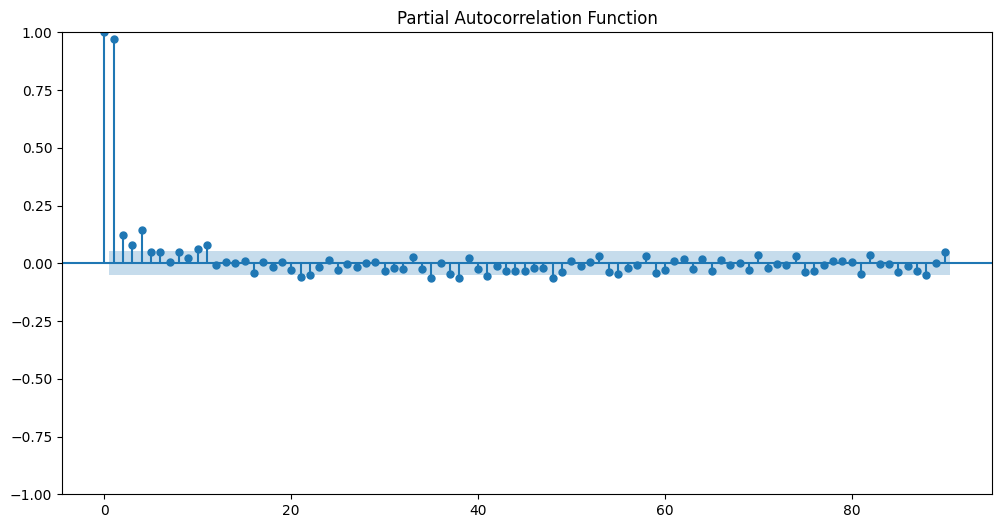

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(y_train, lags=90, alpha = 0.05, ax = ax) # 5% de significancia
plt.title('Partial Autocorrelation Function')
#ax.set_xticks(range(0, 21, 3))
plt.show()

Del gráfico, se observa que la serie temporal muestra una fuerte dependencia al primer rezago $Y_{t-1}$, además de un pequeño efecto repartido en los primeros 10 días.

Ya conociendo los lags con mayor importancia, veamos como generarlos para nuestro modelo:

In [25]:
from sklearn.preprocessing import FunctionTransformer

def get_lags(X):

    '''
    Retorna variables temporales basadas en lags.
    '''

    lag_features = pd.DataFrame(index = X.index)
    lag_features['lag_1'] = X.shift(1) # lag 1 de la serie
    lag_features['rolling_3'] = X.rolling(3).mean() # media móvil últimos 3 días

    return lag_features[['lag_1', 'rolling_3']]

LagsTransformer = FunctionTransformer(get_lags)
LagsTransformer.transform(X_test['meantemp'])

,lag_1,rolling_3
1461,NaN,NaN
1462,15.913043,NaN
1463,18.500000,17.174718
1464,17.111111,18.103704
1465,18.700000,18.066667
...,...,...
1570,33.500000,34.000000
1571,34.500000,34.083333
1572,34.250000,33.883333
1573,32.900000,33.341667


Noten como se generan valores nulos a partir de los lags, específicamente en 2 filas.

Esta ventana se le conoce como **latencia** y se puede entender como el número de timesteps necesarios para comenzar a generar predicciones usando el modelo (entrenado a partir de los lags). Usaremos esta ventana para analizar el performance de nuestro modelo.

Pasemos ahora a generar el pipeline:

In [26]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# definir latencia
latency = 2

# pipeline para generar rezagos
lag_pipeline = Pipeline([
    ('make_lags', LagsTransformer),
    ('imputer', SimpleImputer(strategy = 'mean')) # imputamos valores nulos por media para mantener las dimensiones de entrada
])

# col transformer para generar features
col_transformer = ColumnTransformer([
    ("time_features", TimeTransformer(), ["date"]),
    ("target_lags", lag_pipeline, target)
])

# generamos pipeline final
pipeline = Pipeline([
    ("column_transformer", col_transformer),
    ("model", LinearRegression())
])

pipeline

,steps,"[('column_transformer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('time_features', ...), ('target_lags', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
col_transformer.fit_transform(X_train).shape

(1461, 11)

Con el pipeline generado, pasemos ahora a entrenar nuestro modelo:

In [28]:
# entrenar modelo
pipeline.fit(X_train, y_train)

# generamos prediccion para train y test
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

# dropear filas según latency
train_pred = train_pred[latency:]
test_pred = test_pred[latency:]

# concatenamos las predicciones para obtener la serie completa
y_pred = np.concatenate([train_pred, test_pred])
y_pred.shape

(1571,)

In [29]:
# dropear filas según latency
new_train = df[df['set'] == 'Train'].iloc[latency:].copy()
new_test = df[df['set'] == 'Test'].iloc[latency:].copy()
new_df = pd.concat([new_train, new_test])

# plot
fig = px.scatter(new_df, x=new_df.date, y=target, title='Forecast de Temperaturas', color='set')
fig.add_scatter(x=new_df.date, y=y_pred, mode='lines', name='Prediction', line=dict(color='green', width=3))
fig.update_traces(marker=dict(size=3.5))
fig.show()

> **Pregunta**: ¿Porqué existen fuertes desajustes al inicio de cada conjunto? ¿Cómo puede arreglarse esto?

In [30]:
# dropear filas según latency
new_ytrain = y_train[latency:].copy()
new_ytest = y_test[latency:].copy()

mae_train = mean_absolute_error(new_ytrain, train_pred)
mae_test = mean_absolute_error(new_ytest, test_pred)

print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')

MAE Train: 0.85
MAE Test: 0.93


In [31]:
# calculamos errores de train y test
error_train = new_ytrain - train_pred
error_test = new_ytest - test_pred
error = pd.concat([error_train, error_test])

# graficamos errores
fig = px.line(x = new_df.date, y=error, title='Error en la predicción', color = new_df.set)
fig.show()

In [32]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(error)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.797353198574836
p-value: 1.2281811516805049e-29
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


### Residuo

A lo largo de la clase, hemos aprendido sobre los diferentes componentes de una serie de tiempo. Además, hemos controlado poco a poco cada uno de estos componentes, mejorando cada vez mas nuestro forecast y cambiando la distribución de los errores en la predicción. Conceptualmente, lo que hemos hecho sigue el siguiente procedimiento:

<div style="text-align: center;">
    <img src="https://storage.googleapis.com/kaggle-media/learn/images/XGJuheO.png" style="width: 65%;">
</div>

El componente **residual** resulta de eliminar las tendencias, estacionalidad y ciclicidad de una serie temporal. Si asumimos que la relación entre los componentes es aditiva, la fórmula para identificar este componente residual se expresa como:

$$ I = Y - (T + E + C)$$

donde $Y$ representa la serie temporal original, $T$ la tendencia, $E$ la estacionalidad, y $C$ la ciclidad. Tradicionalmente, el irregular se considera impredecible y es conocido como el **término residual o de error**. Este término encapsula todas las fluctuaciones de la serie temporal que no pueden ser explicadas por los modelos aplicados a las tendencias, los patrones estacionales o los ciclos identificados.

En los modelos estadísticos clásicos, el objetivo es capturar todos los componentes hasta que solo quede el componente irregular sin explicar (y asegurando que posea las propiedades de una serie estacionaria). Sin embargo y bajo el paradigma de machine learning moderno, **este componente no se considera totalmente impredecible**. Es posible capturarlo (o partes de él) usando **variables exógenas** a la serie objetivo.

Por ejemplo, el componente irregular en las ventas al por menor podría explicarse por las distintas actividades promocionales que se implementan. Con esta información adicional, el componente anteriormente "impredecible" comienza a ser predecible. Aun así, por más variables que se añadan al modelo, siempre permanecerá algún componente verdaderamente irregular (o error verdadero) que no se puede capturar completamente.

Conozcamos como podemos implementar lo anterior:

### Modelos Híbridos

En las secciones anteriores, utilizamos un único algoritmo (regresión lineal) para aprender todos los componentes a la vez. Sin embargo, también es posible usar **un algoritmo para algunos de los componentes y otro algoritmo para el resto**. De esta manera, siempre podemos elegir el mejor algoritmo para cada componente. Para hacer esto, usamos un algoritmo para ajustar la serie original y luego un **segundo algoritmo para ajustar la serie residual.**

Típicamente es deseable que estos modelos usen features distintas (`X_train_1`, `X_train_2`) dependiendo de lo que queramos que cada modelo aprenda. Por ejemplo, si usamos un modelo para aprender tendencia, no necesitaríamos una característica de tendencia en el siguiente modelo.

Aunque es posible usar más de dos modelos, en la práctica este enfoque no es tan utilizado. De hecho, la estrategia más común para construir modelos híbridos sigue los siguientes lineamientos:

- Un algoritmo simple de machine learning (**generalmente lineal**) para modelar componentes temporales y cíclicas
- Un algoritmo complejo y no lineal de machine learning como `XGBoost` o una red neuronal para modelar el componente residual

> **Pregunta:** ¿Qué otro modelo lineal podríamos aplicar?

> **Pregunta:** ¿Qué desventajas podría tener este enfoque?

De esta manera, la idea es que el modelo simple sea un "ayudante" para capturar el efecto temporal de la serie y así el algoritmo complejo pueda atacar el componente irregular de la serie.

Si bien es posible usar algoritmos complejos en ambos puntos, tengan cuidado con el tipo de algoritmo que utilizan para modelar las componentes. Por ejemplo, modelos ensemble basados en árboles de decisión son incapaces de obtener una buena representación de la tendencia de una serie temporal.

Considerando lo anterior, implementemos un modelo híbrido en python:

In [33]:
# primero obtendremos un lag de las variables exógenas
# de lo contrario asumimos que disponemos de humidity, wind_speed y meanpressure antes que la temperatura
# y eso no necesariamente es cierto (cuidado con el data leakage!)
def get_exogenous_lags(X):

    '''
    Retorna el primer lag de variables exógenas
    '''

    return X.shift(1)

LagsExogenousTransformer = FunctionTransformer(get_exogenous_lags)

Encapsulamos todo el procesamiento en 2 pipelines:

In [34]:
from xgboost import XGBRegressor

# modelo lineal
linear_features_pipeline = Pipeline([
    ('make_lags', LagsTransformer),
    ('imputer', SimpleImputer(strategy = 'mean')) # imputamos valores nulos por media para mantener las dimensiones de entrada
])

linear_col_transformer = ColumnTransformer([
    ("time_features", TimeTransformer(), ["date"]),
    ("target_lags", linear_features_pipeline, target)
])

linear_pipeline = Pipeline([
    ("column_transformer", linear_col_transformer),
    ("model", LinearRegression())
])

# modelo residual
residual_features_pipeline = Pipeline([
    ('make_lags', LagsExogenousTransformer),
    ('imputer', SimpleImputer(strategy = 'mean')) # imputamos valores nulos por media para mantener las dimensiones de entrada
])

residual_col_transformer = ColumnTransformer([
    ('make_lags', residual_features_pipeline, ['humidity', 'wind_speed', 'meanpressure'])
])

residual_pipeline = Pipeline([
    ('col_transformer', residual_col_transformer),
    ('model', XGBRegressor(seed = 3380))
])

Con los pipelines, podemos entrenar los modelos:

In [35]:
# MODELO LINEAL
# entrenamos modelo lineal
linear_pipeline.fit(X_train, y_train)
# luego generamos la prediccion del modelo
linear_pred_train = linear_pipeline.predict(X_train)

# MODELO RESIDUAL
# primero generamos el término residual
error = y_train - linear_pred_train

# entrenamos xgboost
residual_pipeline.fit(X_train, error)

,steps,"[('col_transformer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('make_lags', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Generamos predicciones:

In [36]:
# luego la predicción para test viene dada por
linear_pred_test = linear_pipeline.predict(X_test)
residual_pred_test = residual_pipeline.predict(X_test)
final_pred_test = linear_pred_test + residual_pred_test

# lo mismo para train
linear_pred_train = linear_pipeline.predict(X_train)
residual_pred_train = residual_pipeline.predict(X_train)
final_pred_train = linear_pred_train + residual_pred_train

# dropear filas según latency
final_pred_train = final_pred_train[latency:].copy()
final_pred_test = final_pred_test[latency:].copy()

# finalmente podemos generar la predicción para toda la serie
final_pred = np.concatenate([final_pred_train, final_pred_test])

Visualicemos ahora el ajuste de nuestro modelo híbrido:

In [37]:
# dropear filas según latency
new_train = df[df['set'] == 'Train'].iloc[latency:].copy()
new_test = df[df['set'] == 'Test'].iloc[latency:].copy()
new_df = pd.concat([new_train, new_test])

# plot
fig = px.scatter(new_df, x=new_df.date, y=target, title='Forecast de Temperaturas', color='set')
fig.add_scatter(x=new_df.date, y=y_pred, mode='lines', name='Prediction', line=dict(color='green', width=3))
fig.update_traces(marker=dict(size=3.5))
fig.show()

Finalmente analicemos los errores en los conjuntos de entrenamiento y test:

In [38]:
# dropear filas según latency
new_ytrain = y_train[latency:].copy()
new_ytest = y_test[latency:].copy()

mae_train = mean_absolute_error(new_ytrain, final_pred_train)
mae_test = mean_absolute_error(new_ytest, final_pred_test)

print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')

MAE Train: 0.23
MAE Test: 1.04


Notamos que la métrica en entrenamiento bajó notablemente (-0.6 de MAE!), mientras que la métrica de test sube levemente (+0.1 MAE). Esto es un claro indicio de que nuestro modelo puede estar overfiteando a los datos.

> **Pregunta:** ¿Cómo podríamos reducir el overfit de nuestro modelo?

In [39]:
# calculamos errores de train y test
error_train = new_ytrain - train_pred
error_test = new_ytest - test_pred
error = pd.concat([error_train, error_test])

# graficamos errores
fig = px.line(x = new_df.date, y=error, title='Error en la predicción', color = new_df.set)
fig.show()

## Bibliografía

- [Modern Time Series Forecasting with Pytthon](https://www.oreilly.com/library/view/modern-time-series/9781803246802/)
- [Kaggle](https://www.kaggle.com/learn/time-series)
- [Forecasting: Principles and Practice](https://otexts.com/fpp2/)